In [15]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.stats import norm
# from scipy.optimize import brentq

# # Black-Scholes formula for a European Call Option
# def black_scholes_call_price(S, K, T, r, sigma):
#     if S <= 0 or sigma <= 0 or T <= 0:
#         return 0.0
#     d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
#     d2 = d1 - sigma * np.sqrt(T)
#     call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
#     return call_price

# def implied_volatility(call_price, spot, strike, time_to_expiry):
#     # Define the equation where the root is the implied volatility
#     def equation(volatility):
#         estimated_price = black_scholes_call_price(spot, strike, time_to_expiry, 0, volatility)
#         return estimated_price - call_price

#     # Using Brent's method to find the root of the equation
#     implied_vol = brentq(equation, -1e-10, 3)
#     return implied_vol

# # Load CSV-like data
# data = pd.read_csv("round-3-island-data-bottle/prices_round_3_day_0.csv", sep=';')

# # Convert necessary columns to numeric
# data['mid_price'] = pd.to_numeric(data['mid_price'], errors='coerce')
# data['timestamp'] = pd.to_numeric(data['timestamp'], errors='coerce')

# # Filter product types
# rock_data = data[data['product'] == 'VOLCANIC_ROCK'].copy()
# voucher_data = data[data['product'] == 'VOLCANIC_ROCK_VOUCHER_10500'].copy()
# voucher_data = voucher_data.merge(rock_data[['timestamp', 'mid_price']], on='timestamp', suffixes=('', '_volcanic_rock'))

# # Estimate volatility from log returns of underlying asset
# rock_data = rock_data.sort_values(by='timestamp')
# rock_data['log_return'] = np.log(rock_data['mid_price'] / rock_data['mid_price'].shift(1))
# volatility = rock_data['log_return'].std() * np.sqrt(1_000_000)  # Annualize from per-tick std

# # Constants
# K = 10500
# total_time = 8 / 365  # in years
# r = 0

# # Interpolate S (underlying price) for each voucher timestamp
# interpolated_S = np.interp(voucher_data['timestamp'], rock_data['timestamp'], rock_data['mid_price'])

# # Compute T per row based on how much time is left until expiration
# # 1,000,000 timestamps/day × 5 days = 5,000,000 ticks total
# ticks_per_day = 1_000_000
# total_ticks = 8 * ticks_per_day
# voucher_data = voucher_data.copy()
# voucher_data['S'] = interpolated_S
# voucher_data['T'] = (total_ticks - voucher_data['timestamp']) / total_ticks * total_time
# voucher_data['implied_vol'] = voucher_data.apply(lambda row: implied_volatility(row['mid_price'], row['mid_price_volcanic_rock'], K, row['T']), axis=1)
# voucher_data['bs_price'] = voucher_data.apply(lambda row: black_scholes_call_price(row['S'], K, row['T'], r, row['implied_vol']), axis=1)

# print(np.mean(voucher_data['implied_vol']))

# # Plot actual vs theoretical
# plt.figure(figsize=(12, 6))
# plt.plot(voucher_data['timestamp'], voucher_data['mid_price'], label='Actual Voucher Mid Price', alpha=0.5)
# plt.plot(voucher_data['timestamp'], voucher_data['bs_price'], label='Black-Scholes Price', alpha=0.5)
# plt.xlabel('Timestamp')
# plt.ylabel('Price')
# plt.title('Actual vs Theoretical Price of VOLCANIC_ROCK_VOUCHER_10500')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [35]:
# # Compute m_t and v_t
# voucher_data['m_t'] = np.log(K / voucher_data['S']) / np.sqrt(voucher_data['T'])
# voucher_data['v_t'] = voucher_data['implied_vol']

# # Fit a parabola: v_t = a * m_t^2 + b * m_t + c
# coeffs = np.polyfit(voucher_data['m_t'], voucher_data['v_t'], 2)
# parabola = np.poly1d(coeffs)

# # Store fitted values
# voucher_data['v_t_fitted'] = parabola(voucher_data['m_t'])

# # Evaluate base IV (at m_t = 0)
# base_iv = parabola(0)
# print(f"Base IV (v_t at m_t = 0): {base_iv}")

# # Plot v_t vs m_t and the parabolic fit
# plt.figure(figsize=(10, 6))
# plt.scatter(voucher_data['m_t'], voucher_data['v_t'], alpha=0.3, label='Observed IV')
# m_range = np.linspace(voucher_data['m_t'].min(), voucher_data['m_t'].max(), 500)
# plt.plot(m_range, parabola(m_range), color='red', label='Parabolic Fit', linewidth=2)
# plt.xlabel('m_t = log(K/S_t) / sqrt(TTE)')
# plt.ylabel('Implied Volatility (v_t)')
# plt.title('Volatility Smile for VOLCANIC_ROCK_VOUCHER_10500')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


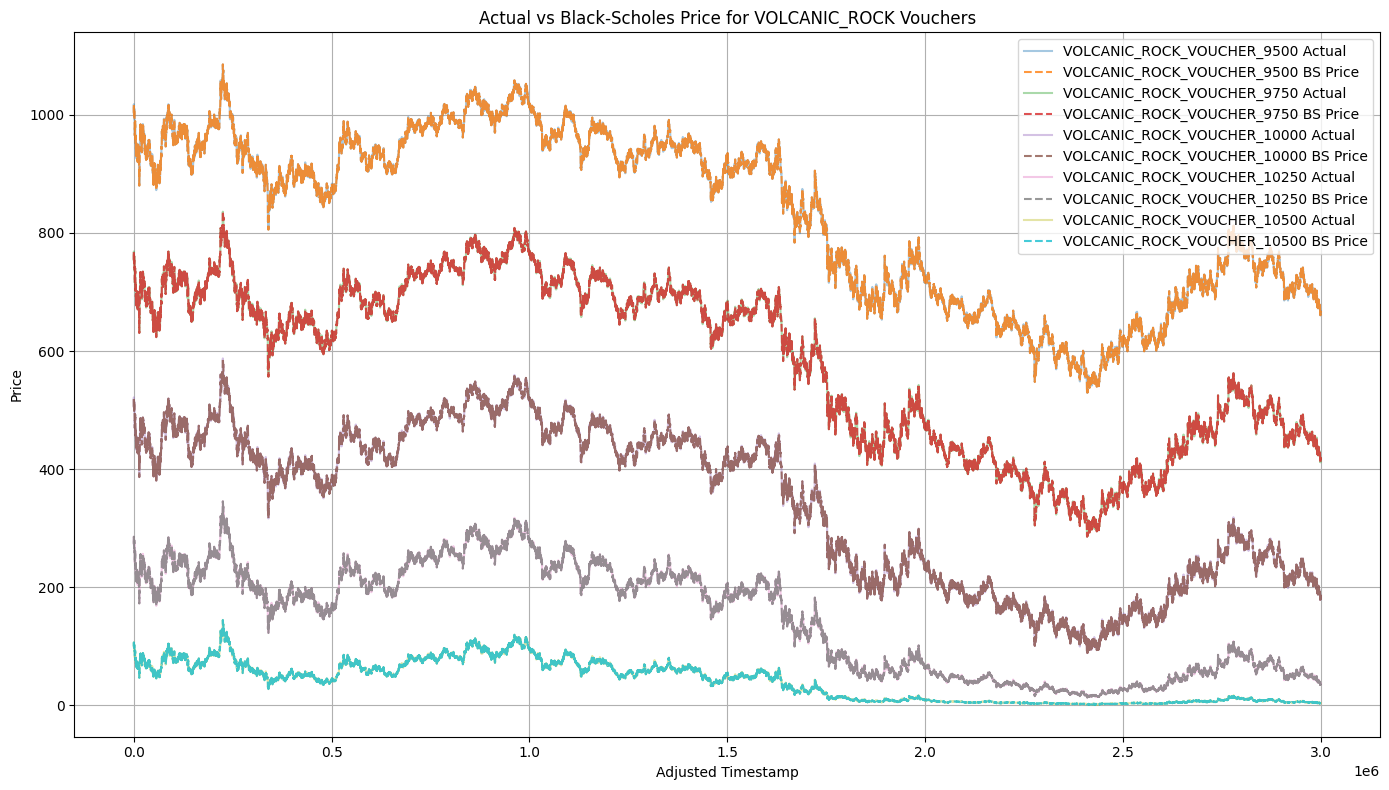

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq

# Black-Scholes formula for a European Call Option
def black_scholes_call_price(S, K, T, r, sigma):
    if S <= 0 or sigma <= 0 or T <= 0:
        return 0.0
    d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def implied_volatility(call_price, spot, strike, time_to_expiry):
    def equation(volatility):
        estimated_price = black_scholes_call_price(spot, strike, time_to_expiry, 0, volatility)
        return estimated_price - call_price
    try:
        return brentq(equation, 1e-6, 3)
    except ValueError:
        return np.nan

# Load and concatenate all 3 days of data
files = [
    "round-3-island-data-bottle/prices_round_3_day_0.csv",
    "round-3-island-data-bottle/prices_round_3_day_1.csv",
    "round-3-island-data-bottle/prices_round_3_day_2.csv"
]

data = pd.concat([pd.read_csv(f, sep=';') for f in files], ignore_index=True)

# Convert types
data['mid_price'] = pd.to_numeric(data['mid_price'], errors='coerce')
data['timestamp'] = pd.to_numeric(data['timestamp'], errors='coerce')
data['day'] = pd.to_numeric(data['day'], errors='coerce')

# Adjust timestamps by adding 1,000,000 per day
ticks_per_day = 1_000_000
data['timestamp'] += data['day'] * ticks_per_day

# Filter for VOLCANIC_ROCK
rock_data = data[data['product'] == 'VOLCANIC_ROCK'].copy()

# Strike prices
voucher_strikes = {
    'VOLCANIC_ROCK_VOUCHER_9500': 9500,
    'VOLCANIC_ROCK_VOUCHER_9750': 9750,
    'VOLCANIC_ROCK_VOUCHER_10000': 10000,
    'VOLCANIC_ROCK_VOUCHER_10250': 10250,
    'VOLCANIC_ROCK_VOUCHER_10500': 10500,
}

# Time settings
total_days = 8
total_time = total_days / 365  # in years
total_ticks = total_days * ticks_per_day

plt.figure(figsize=(14, 8))

for voucher_name, K in voucher_strikes.items():
    voucher_data = data[data['product'] == voucher_name].copy()
    if voucher_data.empty:
        continue

    # Merge voucher with rock prices
    voucher_data = voucher_data.merge(
        rock_data[['timestamp', 'mid_price']],
        on='timestamp',
        suffixes=('', '_volcanic_rock')
    )

    # Interpolate S (underlying)
    voucher_data['S'] = np.interp(
        voucher_data['timestamp'],
        rock_data['timestamp'],
        rock_data['mid_price']
    )

    # Compute time to expiry
    voucher_data['T'] = (total_ticks - voucher_data['timestamp']) / total_ticks * total_time

    # Implied vol
    voucher_data['implied_vol'] = voucher_data.apply(
        lambda row: implied_volatility(
            row['mid_price'], row['mid_price_volcanic_rock'], K, row['T']
        ), axis=1
    )

    # BS price
    r = 0
    voucher_data['bs_price'] = voucher_data.apply(
        lambda row: black_scholes_call_price(
            row['S'], K, row['T'], r, row['implied_vol']
        ), axis=1
    )

    # Plot
    plt.plot(
        voucher_data['timestamp'],
        voucher_data['mid_price'],
        label=f'{voucher_name} Actual',
        alpha=0.4
    )
    plt.plot(
        voucher_data['timestamp'],
        voucher_data['bs_price'],
        label=f'{voucher_name} BS Price',
        linestyle='--',
        alpha=0.8
    )

plt.xlabel('Adjusted Timestamp')
plt.ylabel('Price')
plt.title('Actual vs Black-Scholes Price for VOLCANIC_ROCK Vouchers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
all_vouchers = []

for voucher_name, K in voucher_strikes.items():
    voucher_data = data[data['product'] == voucher_name].copy()
    voucher_data = voucher_data.merge(rock_data[['timestamp', 'mid_price']], on='timestamp', suffixes=('', '_volcanic_rock'))

    interpolated_S = np.interp(voucher_data['timestamp'], rock_data['timestamp'], rock_data['mid_price'])

    voucher_data['K'] = K
    voucher_data['S'] = interpolated_S
    voucher_data['T'] = (total_ticks - voucher_data['timestamp']) / total_ticks * total_time

    voucher_data['v_t'] = voucher_data.apply(
        lambda row: implied_volatility(row['mid_price'], row['mid_price_volcanic_rock'], row['K'], row['T']), axis=1
    )

    voucher_data['m_t'] = np.log(voucher_data['K'] / voucher_data['S']) / np.sqrt(voucher_data['T'])

    all_vouchers.append(voucher_data[['timestamp', 'K', 'S', 'T', 'mid_price', 'v_t', 'm_t']])

# Combine data
combined_df = pd.concat(all_vouchers).dropna()

# Fit v_t = a*m_t^2 + b*m_t + c at each timestamp
signal_rows = []

for ts, group in combined_df.groupby('timestamp'):
    if len(group) < 3:
        continue  # Need at least 3 points to fit parabola

    m = group['m_t'].values
    v = group['v_t'].values

    # Fit quadratic: v_t = a*m^2 + b*m + c
    coeffs = np.polyfit(m, v, 2)
    a, b, c = coeffs
    fitted_v = np.polyval(coeffs, m)

    group = group.copy()
    group['v_t_fitted'] = fitted_v
    group['iv_diff'] = group['v_t'] - group['v_t_fitted']
    group['zscore'] = (group['iv_diff'] - group['iv_diff'].mean()) / group['iv_diff'].std()

    # Base IV = fitted value at m_t = 0
    base_iv = np.polyval(coeffs, 0)
    group['base_iv'] = base_iv
    group['a'] = a
    group['b'] = b
    group['c'] = c

    signal_rows.append(group)

signal_df = pd.concat(signal_rows)

# Flag opportunities
signal_df['signal'] = 'HOLD'
signal_df.loc[signal_df['zscore'] > 1.5, 'signal'] = 'SELL'
signal_df.loc[signal_df['zscore'] < -1.5, 'signal'] = 'BUY'

# View some sample opportunities
print(signal_df[signal_df['signal'] != 'HOLD'][['timestamp', 'K', 'm_t', 'v_t', 'v_t_fitted', 'zscore', 'signal']].head())

   timestamp      K       m_t       v_t  v_t_fitted    zscore signal
1        100  10250 -0.169201  0.163284    0.170952 -1.588905    BUY
2        200   9750 -0.508936  0.227530    0.219333  1.574017   SELL
6        600  10250 -0.165027  0.161988    0.158256  1.536431   SELL
7        700   9750 -0.502523  0.196800    0.209008 -1.530406    BUY
8        800   9750 -0.498988  0.000001    0.065260 -1.532338    BUY


In [ ]:
ts = signal_df['timestamp'].iloc[3000]  # Pick any timestamp

subset = signal_df[signal_df['timestamp'] == ts]
m_plot = np.linspace(min(subset['m_t']), max(subset['m_t']), 100)
fitted_v = np.polyval([subset['a'].iloc[0], subset['b'].iloc[0], subset['c'].iloc[0]], m_plot)

plt.figure(figsize=(10, 6))
plt.scatter(subset['m_t'], subset['v_t'], label='Market IV', color='blue')
plt.plot(m_plot, fitted_v, label='Fitted Smile', color='orange')
plt.axvline(0, color='gray', linestyle='--')
plt.title(f'Volatility Smile at timestamp {ts}')
plt.xlabel('m_t = log(K/S) / sqrt(T)')
plt.ylabel('Implied Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

ValueError: Can only compare identically-labeled Series objects

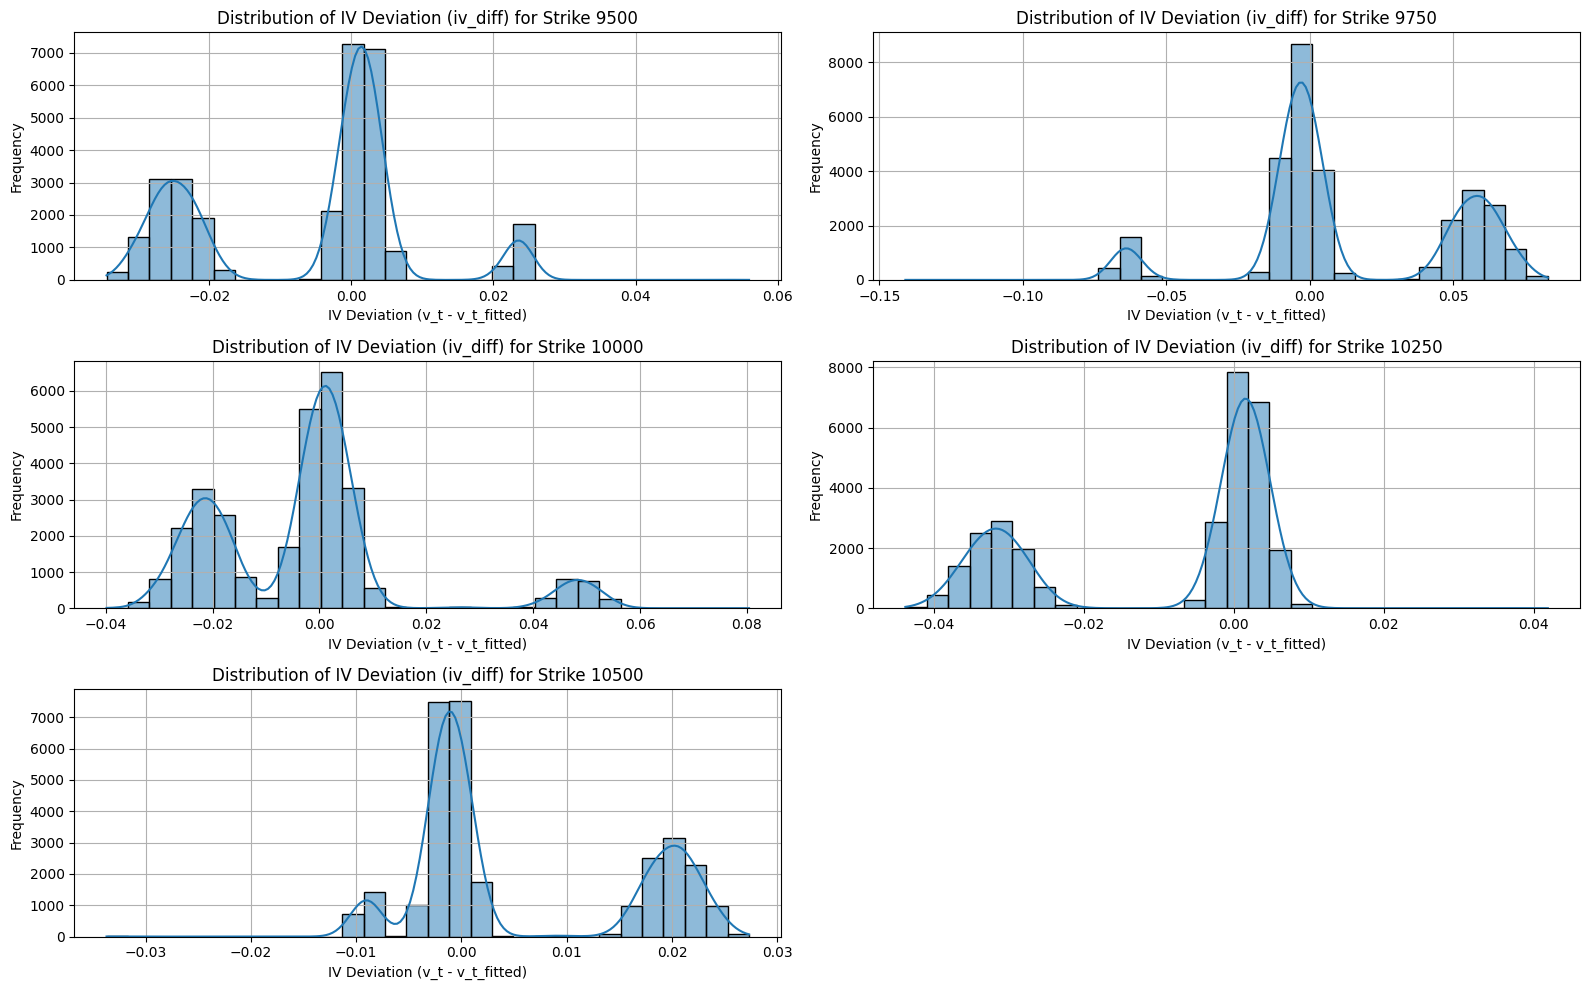

In [21]:
import seaborn as sns

# Create a plot for each voucher to show distribution of deviations from the fitted smile
voucher_names = signal_df['K'].unique()
plt.figure(figsize=(16, 10))

for i, strike in enumerate(sorted(voucher_names), 1):
    plt.subplot(3, 2, i)
    subset = signal_df[signal_df['K'] == strike]
    sns.histplot(subset['iv_diff'], kde=True, bins=30)
    plt.title(f'Distribution of IV Deviation (iv_diff) for Strike {strike}')
    plt.xlabel('IV Deviation (v_t - v_t_fitted)')
    plt.ylabel('Frequency')
    plt.grid(True)

plt.tight_layout()
plt.show()

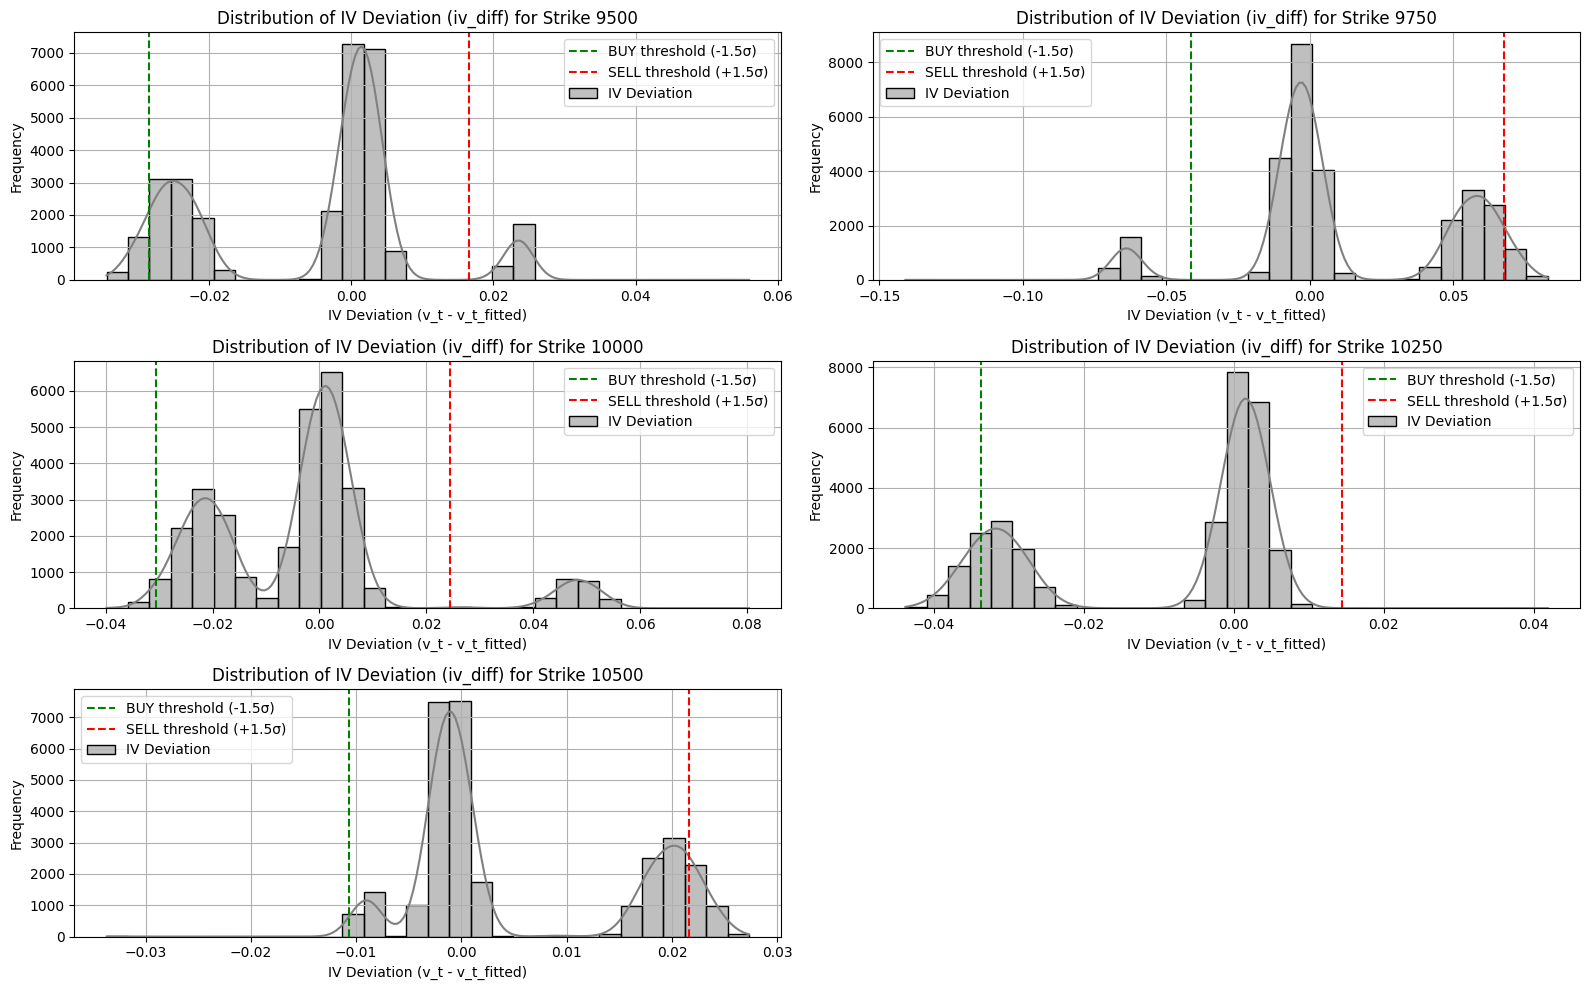

In [23]:

plt.figure(figsize=(16, 10))

for i, strike in enumerate(sorted(voucher_names), 1):
    plt.subplot(3, 2, i)
    subset = signal_df[signal_df['K'] == strike]

    # Calculate thresholds for BUY/SELL based on z-scores
    iv_mean = subset['iv_diff'].mean()
    iv_std = subset['iv_diff'].std()
    buy_thresh = iv_mean - 1.5 * iv_std
    sell_thresh = iv_mean + 1.5 * iv_std

    # Plot histogram with KDE
    sns.histplot(subset['iv_diff'], kde=True, bins=30, color='gray', label='IV Deviation')

    # Highlight BUY/SELL zones
    plt.axvline(buy_thresh, color='green', linestyle='--', label='BUY threshold (-1.5σ)')
    plt.axvline(sell_thresh, color='red', linestyle='--', label='SELL threshold (+1.5σ)')

    plt.title(f'Distribution of IV Deviation (iv_diff) for Strike {strike}')
    plt.xlabel('IV Deviation (v_t - v_t_fitted)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


601   -0.608807
601   -0.432689
601   -0.261031
601   -0.093611
601    0.069774
Name: m_t, dtype: float64
601   -0.608807
601   -0.432689
601   -0.261031
601   -0.093611
601    0.069774
Name: m_t, dtype: float64
601   -0.608807
601   -0.432689
601   -0.261031
601   -0.093611
601    0.069774
Name: m_t, dtype: float64
601   -0.608807
601   -0.432689
601   -0.261031
601   -0.093611
601    0.069774
Name: m_t, dtype: float64
601   -0.608807
601   -0.432689
601   -0.261031
601   -0.093611
601    0.069774
Name: m_t, dtype: float64
602   -0.610767
602   -0.434649
602   -0.262989
602   -0.095569
602    0.067817
Name: m_t, dtype: float64
602   -0.610767
602   -0.434649
602   -0.262989
602   -0.095569
602    0.067817
Name: m_t, dtype: float64
602   -0.610767
602   -0.434649
602   -0.262989
602   -0.095569
602    0.067817
Name: m_t, dtype: float64
602   -0.610767
602   -0.434649
602   -0.262989
602   -0.095569
602    0.067817
Name: m_t, dtype: float64
602   -0.610767
602   -0.434649
602   -0.26298

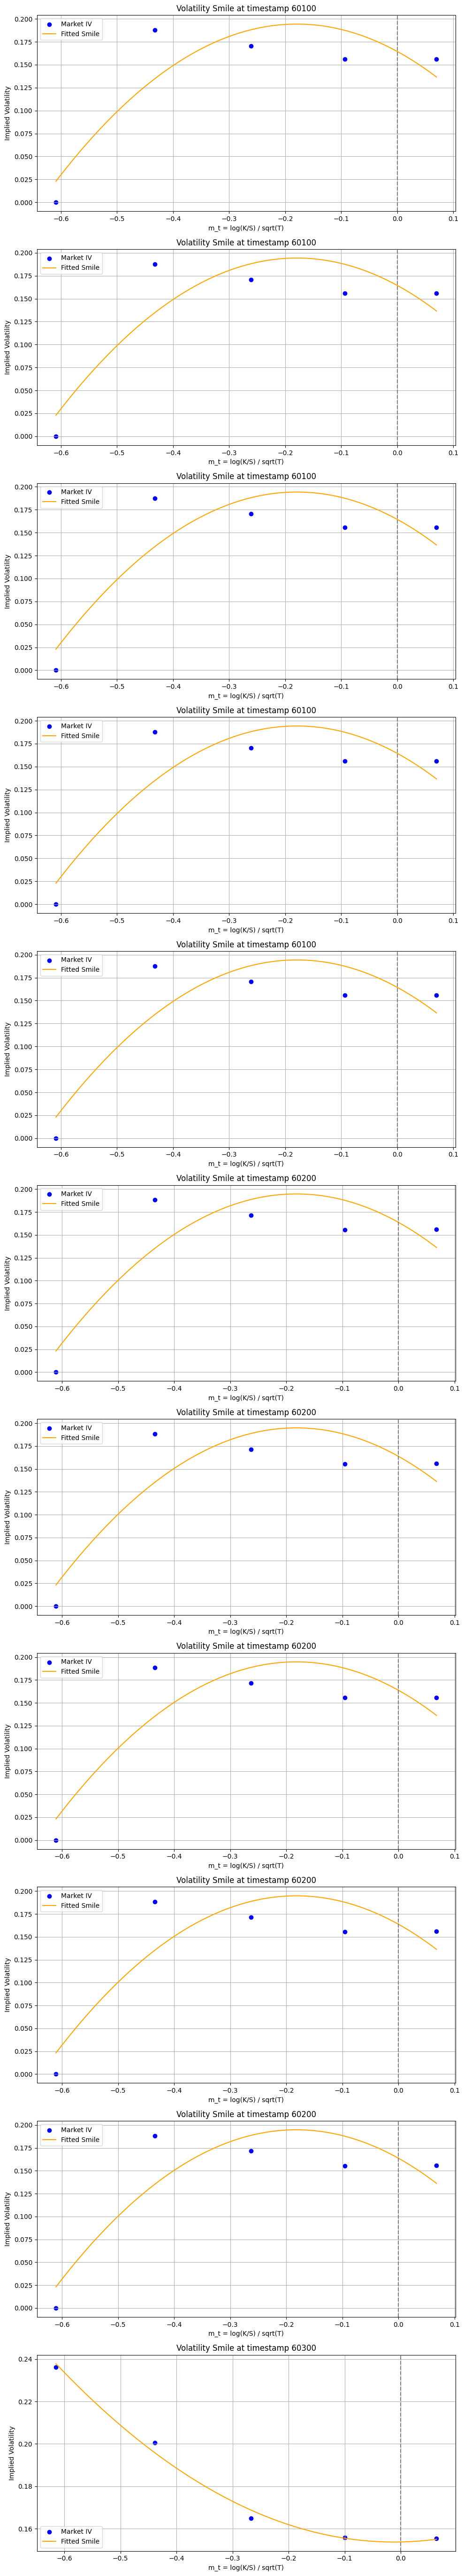

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the range of indices
start_idx = 3000
end_idx = 3010
n_rows = end_idx - start_idx + 1

# Create a figure with subplots
fig, axs = plt.subplots(n_rows, 1, figsize=(10, 5 * n_rows))

for i, idx in enumerate(range(start_idx, end_idx + 1)):
    ts = signal_df['timestamp'].iloc[idx]
    subset = signal_df[signal_df['timestamp'] == ts]

    m_plot = np.linspace(min(subset['m_t']), max(subset['m_t']), 100)
    fitted_v = np.polyval([subset['a'].iloc[0], subset['b'].iloc[0], subset['c'].iloc[0]], m_plot)

    ax = axs[i] if n_rows > 1 else axs  # handle case of a single subplot
    ax.scatter(subset['m_t'], subset['v_t'], label='Market IV', color='blue')
    ax.plot(m_plot, fitted_v, label='Fitted Smile', color='orange')
    ax.axvline(0, color='gray', linestyle='--')
    ax.set_title(f'Volatility Smile at timestamp {ts}')
    ax.set_xlabel('m_t = log(K/S) / sqrt(T)')
    ax.set_ylabel('Implied Volatility')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()
